In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Read CSV files
polymarket = pd.read_csv("../output/polymarket_data.csv")
betfair = pd.read_csv("../output/betfair_data.csv")
oddschecker = pd.read_csv("../output/oddschecker_data.csv")
predictit = pd.read_csv("../output/predictit_data.csv")

#### Process datasets

In [45]:
# Convert 'timestamp' to datetime
for df in [polymarket, betfair, oddschecker, predictit]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Process each DataFrame to have consistent columns
# [Process oddschecker]
oddschecker = oddschecker[oddschecker['bet_name'].isin(['Donald Trump', 'Kamala Harris'])]
oddschecker_melted = oddschecker.melt(
    id_vars=['bet_name', 'timestamp'],
    var_name='source',
    value_name='value'
)
oddschecker_melted['value'] = pd.to_numeric(oddschecker_melted['value'], errors='coerce')
oddschecker_melted = oddschecker_melted[oddschecker_melted['source'].isin(['WH', 'SK', 'BF'])]
oddschecker_melted.rename(columns={'bet_name': 'market'}, inplace=True)
oddschecker_prices = oddschecker_melted[['timestamp', 'market', 'source', 'value']]

# [Process betfair]
betfair['market'] = betfair['bet_name']
betfair['source'] = 'betfairx'
betfair_prices = betfair[['timestamp', 'market', 'source', 'back_price']].rename(columns={'back_price': 'value'})

# [Process polymarket]
polymarket['market'] = polymarket['bet_id'].apply(
    lambda x: 'Donald Trump' if x == 253591 else 'Kamala Harris'
)
polymarket['source'] = 'polymarket'
polymarket['value'] = 1/polymarket['yes_price']
polymarket_prices = polymarket[['timestamp', 'market', 'source', 'value']]

# [Process predictit]
predictit['market'] = predictit['bet_name']
predictit['source'] = 'predictit'
predictit['value'] = 1/predictit['buy_yes_price']
predictit_prices = predictit[['timestamp', 'market', 'source', 'value']]

# Combine all prices
prices = pd.concat([oddschecker_prices, betfair_prices, polymarket_prices, predictit_prices], ignore_index=True)

# Ensure 'value' is numeric
prices['value'] = pd.to_numeric(prices['value'], errors='coerce')
prices = prices.dropna(subset=['value'])


In [46]:
# Display the resulting DataFrame
# Convert 'timestamp' to datetime if not already
prices['timestamp'] = pd.to_datetime(prices['timestamp'])

# Set 'timestamp' as the index for resampling
prices.set_index('timestamp', inplace=True)

print(prices)

                             timestamp         market     source      value
0     2024-10-30 19:01:37.317865+00:00   Donald Trump         BF   1.550000
1     2024-10-30 19:01:37.317865+00:00  Kamala Harris         BF   2.740000
2     2024-10-30 19:02:51.730743+00:00   Donald Trump         BF   1.550000
3     2024-10-30 19:02:51.730743+00:00  Kamala Harris         BF   2.740000
4     2024-10-30 19:04:04.982139+00:00   Donald Trump         BF   1.550000
...                                ...            ...        ...        ...
59441 2024-11-06 09:37:30.261213+00:00  Kamala Harris  predictit  33.333333
59442 2024-11-06 09:38:30.611898+00:00   Donald Trump  predictit   1.020408
59443 2024-11-06 09:38:30.611898+00:00  Kamala Harris  predictit  33.333333
59444 2024-11-06 09:39:30.967674+00:00   Donald Trump  predictit   1.020408
59445 2024-11-06 09:39:30.967674+00:00  Kamala Harris  predictit  33.333333

[59174 rows x 4 columns]


In [87]:
# Resample the data to fixed intervals (e.g., every minute), aggregating only the 'value' column
resampled_prices = prices.groupby(['market', 'source'])['value'].resample('1 min').last()

# Reset index to turn 'timestamp' back into a column
resampled_prices = resampled_prices.reset_index()

In [66]:
resampled_prices.head()

,market,source,timestamp,value
0,Donald Trump,BF,2024-10-30 19:00:00+00:00,1.55
1,Donald Trump,BF,2024-10-30 20:00:00+00:00,1.55
2,Donald Trump,BF,2024-10-30 21:00:00+00:00,1.55
3,Donald Trump,BF,2024-10-30 22:00:00+00:00,1.55
4,Donald Trump,BF,2024-10-30 23:00:00+00:00,1.56


In [67]:
# Step 3: Forward-Fill with Maximum Time Delta
max_delta = pd.Timedelta(minutes=15)

def forward_fill_with_time_limit(group):
    group = group.copy()
    group['value_ffill'] = group['value'].ffill()
    group['original_timestamp'] = group['timestamp'].where(group['value'].notnull())
    group['original_timestamp'] = group['original_timestamp'].ffill()
    group['time_diff'] = group['timestamp'] - group['original_timestamp']
    group.loc[group['time_diff'] > max_delta, 'value_ffill'] = np.nan
    return group

resampled_prices = resampled_prices.groupby(['market', 'source']).apply(forward_fill_with_time_limit).reset_index(drop=True)

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_86658/2424392235.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_prices = resampled_prices.groupby(['market', 'source']).apply(forward_fill_with_time_limit).reset_index(drop=True)


In [68]:
pivoted_prices = resampled_prices.pivot_table(values='value_ffill', index='timestamp', columns=['market', 'source'])
pivoted_prices.columns = ['_'.join(col).strip() for col in pivoted_prices.columns.values]
pivoted_prices.reset_index(inplace=True)

In [51]:
pivoted_prices.to_csv('../output/prices.csv',index=False)

In [69]:
markets = ['Donald Trump', 'Kamala Harris']
best_odds_list = []

for market in markets:
    market_cols = [col for col in pivoted_prices.columns if col.startswith(market)]
    market_df = pivoted_prices[['timestamp'] + market_cols].copy()

    def get_best_odds(row):
        odds = row[1:]
        if odds.isnull().all():
            return pd.Series([np.nan, np.nan])
        best_value = odds.max()
        best_source = odds.idxmax().split('_')[1]
        return pd.Series([best_value, best_source])

    market_df[['best_value', 'best_source']] = market_df.apply(get_best_odds, axis=1)
    market_df['market'] = market
    best_odds_list.append(market_df[['timestamp', 'market', 'best_value', 'best_source']])

best_odds_df = pd.concat(best_odds_list, ignore_index=True)

In [70]:
best_odds_pivot = best_odds_df.pivot(index='timestamp', columns='market', values=['best_value', 'best_source'])
best_odds_pivot.columns = ['_'.join(col).strip() for col in best_odds_pivot.columns.values]
best_odds_pivot.dropna(inplace=True)
best_odds_pivot.reset_index(inplace=True)

In [71]:
best_odds_pivot.head()

,timestamp,best_value_Donald Trump,best_value_Kamala Harris,best_source_Donald Trump,best_source_Kamala Harris
0,2024-10-30 17:00:00+00:00,1.694915,2.95421,predictit,polymarket
1,2024-10-30 18:00:00+00:00,1.724138,2.962963,predictit,polymarket
2,2024-10-30 19:00:00+00:00,1.724138,2.945508,predictit,polymarket
3,2024-10-30 20:00:00+00:00,1.724138,2.911208,predictit,polymarket
4,2024-10-30 21:00:00+00:00,1.724138,2.911208,predictit,polymarket


In [72]:
for market in markets:
    best_odds_pivot[f'implied_prob_{market}'] = 1 / best_odds_pivot[f'best_value_{market}']

implied_prob_cols = [f'implied_prob_{market}' for market in markets]
best_odds_pivot['overround'] = best_odds_pivot[implied_prob_cols].sum(axis=1)

arbitrage_opportunities = best_odds_pivot[best_odds_pivot['overround'] < 1].copy()
arbitrage_opportunities['profit_margin'] = (1 - arbitrage_opportunities['overround']) * 100

# Step 8: Display Results
print("\nArbitrage Opportunities with Best Providers (Aligned Timestamps):")
print(arbitrage_opportunities[['timestamp',
                               'best_value_Donald Trump', 'best_source_Donald Trump',
                               'best_value_Kamala Harris', 'best_source_Kamala Harris',
                               'overround', 'profit_margin']].head())


Arbitrage Opportunities with Best Providers (Aligned Timestamps):
                  timestamp best_value_Donald Trump best_source_Donald Trump  \
0 2024-10-30 17:00:00+00:00                1.694915                predictit   
1 2024-10-30 18:00:00+00:00                1.724138                predictit   
2 2024-10-30 19:00:00+00:00                1.724138                predictit   
3 2024-10-30 20:00:00+00:00                1.724138                predictit   
4 2024-10-30 21:00:00+00:00                1.724138                predictit   

  best_value_Kamala Harris best_source_Kamala Harris overround profit_margin  
0                  2.95421                polymarket    0.9285          7.15  
1                 2.962963                polymarket    0.9175          8.25  
2                 2.945508                polymarket    0.9195          8.05  
3                 2.911208                polymarket    0.9235          7.65  
4                 2.911208                polymarket    0

In [ ]:
arbitrage_opportunities[arbitrage_opportunities['profit_margin']>5].head()

#### Calculate profit

In [73]:
def calculate_arbitrage_with_fixed_stake(best_odds_pivot, fixed_stake_trump=100):
    # Calculate implied profits and required stakes
    results = []
    for idx, row in best_odds_pivot.iterrows():
        # Extract odds and sources
        odds_trump = row['best_value_Donald Trump']
        odds_harris = row['best_value_Kamala Harris']
        source_trump = row['best_source_Donald Trump']
        source_harris = row['best_source_Kamala Harris']
        
        # Check for valid odds
        if pd.notnull(odds_trump) and pd.notnull(odds_harris):
            # Calculate the required stake on Harris
            stake_harris = (fixed_stake_trump * odds_trump) / odds_harris
            
            # Total stakes
            total_stake = fixed_stake_trump + stake_harris
            
            # Profit if Trump wins
            profit_trump = (fixed_stake_trump * odds_trump) - total_stake
            
            # Profit if Harris wins
            profit_harris = (stake_harris * odds_harris) - total_stake
            
            # Record the timestamp and results
            results.append({
                'timestamp': row['timestamp'],
                'odds_trump': odds_trump,
                'source_trump': source_trump,
                'odds_harris': odds_harris,
                'source_harris': source_harris,
                'stake_trump': fixed_stake_trump,
                'stake_harris': stake_harris,
                'total_stake': total_stake,
                'profit_trump': profit_trump,
                'profit_harris': profit_harris,
                'guaranteed_profit': profit_trump  # Should be equal to profit_harris
            })
    # Convert results to DataFrame
    arbitrage_df = pd.DataFrame(results)
    return arbitrage_df

In [74]:
# Apply the function
arbitrage_fixed_stake = calculate_arbitrage_with_fixed_stake(best_odds_pivot, fixed_stake_trump=100)

# Display the results
print("\nArbitrage Opportunities with Fixed Stake on Trump:")
print(arbitrage_fixed_stake[['timestamp', 'odds_trump', 'source_trump', 'odds_harris', 'source_harris',
                             'stake_trump', 'stake_harris', 'total_stake', 'guaranteed_profit']].head())


Arbitrage Opportunities with Fixed Stake on Trump:
                  timestamp  odds_trump source_trump  odds_harris  \
0 2024-10-30 17:00:00+00:00    1.694915    predictit     2.954210   
1 2024-10-30 18:00:00+00:00    1.724138    predictit     2.962963   
2 2024-10-30 19:00:00+00:00    1.724138    predictit     2.945508   
3 2024-10-30 20:00:00+00:00    1.724138    predictit     2.911208   
4 2024-10-30 21:00:00+00:00    1.724138    predictit     2.911208   

  source_harris  stake_trump  stake_harris  total_stake  guaranteed_profit  
0    polymarket          100     57.372881   157.372881          12.118644  
1    polymarket          100     58.189655   158.189655          14.224138  
2    polymarket          100     58.534483   158.534483          13.879310  
3    polymarket          100     59.224138   159.224138          13.189655  
4    polymarket          100     59.224138   159.224138          13.189655  


In [75]:
# Step 2: Simulate Bets at Arbitrage Opportunities
def simulate_bets(arbitrage_df, total_investment=100):
    bets = []
    for idx, row in arbitrage_df.iterrows():
        # Extract odds and sources
        odds_trump = row['best_value_Donald Trump']
        odds_harris = row['best_value_Kamala Harris']
        source_trump = row['best_source_Donald Trump']
        source_harris = row['best_source_Kamala Harris']
        timestamp = row['timestamp']
        
        # Calculate implied probabilities
        implied_prob_trump = 1 / odds_trump
        implied_prob_harris = 1 / odds_harris
        overround = implied_prob_trump + implied_prob_harris
        
        # Check if overround is less than 1 (arbitrage opportunity)
        if overround < 1:
            # Calculate stakes proportionally to guarantee equal profit
            stake_trump = (implied_prob_trump / overround) * total_investment
            stake_harris = (implied_prob_harris / overround) * total_investment
            
            # Record the bets
            bets.append({
                'timestamp': timestamp,
                'candidate': 'Donald Trump',
                'venue': source_trump,
                'stake': stake_trump,
                'odds': odds_trump
            })
            bets.append({
                'timestamp': timestamp,
                'candidate': 'Kamala Harris',
                'venue': source_harris,
                'stake': stake_harris,
                'odds': odds_harris
            })
    bets_df = pd.DataFrame(bets)
    return bets_df

# Step 3: Apply the Function
bets_df = simulate_bets(arbitrage_opportunities, total_investment=100)

# Step 4: Aggregate Bets
aggregated_bets = bets_df.groupby(['candidate', 'venue']).agg({
    'stake': 'sum',
    'odds': lambda x: (x * bets_df.loc[x.index, 'stake']).sum() / bets_df.loc[x.index, 'stake'].sum()
}).reset_index()
aggregated_bets.rename(columns={'odds': 'weighted_avg_odds'}, inplace=True)

# Step 5: Calculate Total Amount Bet
total_bet_candidate = bets_df.groupby('candidate')['stake'].sum().reset_index(name='total_stake')
total_bet = bets_df['stake'].sum()

# Step 6: Calculate Potential Profits
# Potential returns if Trump wins
returns_trump = bets_df[bets_df['candidate'] == 'Donald Trump'].apply(
    lambda x: x['stake'] * x['odds'], axis=1
).sum()

# Potential returns if Harris wins
returns_harris = bets_df[bets_df['candidate'] == 'Kamala Harris'].apply(
    lambda x: x['stake'] * x['odds'], axis=1
).sum()

# Profit if Trump wins
profit_trump = returns_trump - total_bet

# Profit if Harris wins
profit_harris = returns_harris - total_bet

# Step 7: Display Final Results
print("\nFinal Results:")
print(f"Total Amount Bet: ${total_bet:.2f}")
print("\nAggregated Bets per Candidate and Venue:")
print(aggregated_bets)
print("\nTotal Amount Bet on Each Candidate:")
print(total_bet_candidate)
print(f"\nPotential Profit if Trump Wins: ${profit_trump:.2f}")
print(f"Potential Profit if Harris Wins: ${profit_harris:.2f}")


Final Results:
Total Amount Bet: $14400.00

Aggregated Bets per Candidate and Venue:
       candidate       venue        stake  weighted_avg_odds
0   Donald Trump          BF   398.485406           1.050000
1   Donald Trump   predictit  8214.711878           1.815481
2  Kamala Harris          BF   211.256147           3.522408
3  Kamala Harris          WH    44.014085           2.400000
4  Kamala Harris    betfairx  2485.272254           2.477890
5  Kamala Harris  polymarket  3046.260231           2.732552

Total Amount Bet on Each Candidate:
       candidate  total_stake
0   Donald Trump  8613.197284
1  Kamala Harris  5786.802716

Potential Profit if Trump Wins: $932.06
Potential Profit if Harris Wins: $932.06


#### Pricing analysis

In [88]:
# Pivot data to have sources as columns for each market
market = 'Donald Trump'  # Example market
market_data = resampled_prices[resampled_prices['market'] == market]

pivoted_market_data = market_data.pivot(index='timestamp', columns='source', values='value')

# Drop rows with missing values
pivoted_market_data.dropna(inplace=True)

In [117]:
pivoted_market_data.head(n=20)

source,BF,SK,WH,betfairx,polymarket,predictit
timestamp,,,,,,
2024-10-30 19:01:00+00:00,1.55,1.53,1.53,1.56,1.509434,1.724138
2024-10-30 19:02:00+00:00,1.55,1.53,1.53,1.56,1.509434,1.724138
2024-10-30 19:04:00+00:00,1.55,1.53,1.53,1.56,1.511716,1.724138
2024-10-30 19:05:00+00:00,1.55,1.53,1.53,1.56,1.511716,1.724138
2024-10-30 19:06:00+00:00,1.55,1.53,1.53,1.56,1.511716,1.724138
2024-10-30 19:07:00+00:00,1.55,1.53,1.53,1.56,1.511716,1.724138
2024-10-30 19:09:00+00:00,1.55,1.53,1.53,1.56,1.511716,1.724138
2024-10-30 19:28:00+00:00,1.55,1.53,1.53,1.56,1.509434,1.724138
2024-10-30 19:33:00+00:00,1.55,1.53,1.53,1.56,1.509434,1.724138


Stationarity Results:
{'betfairx': {'Test Statistic': 1.4432712376419834, 'p-value': 0.9973021178513034, 'Stationary': False}, 'polymarket': {'Test Statistic': -0.017389316716472245, 'p-value': 0.9570701573678609, 'Stationary': False}, 'predictit': {'Test Statistic': 0.12328723215904822, 'p-value': 0.9676155244455723, 'Stationary': False}}


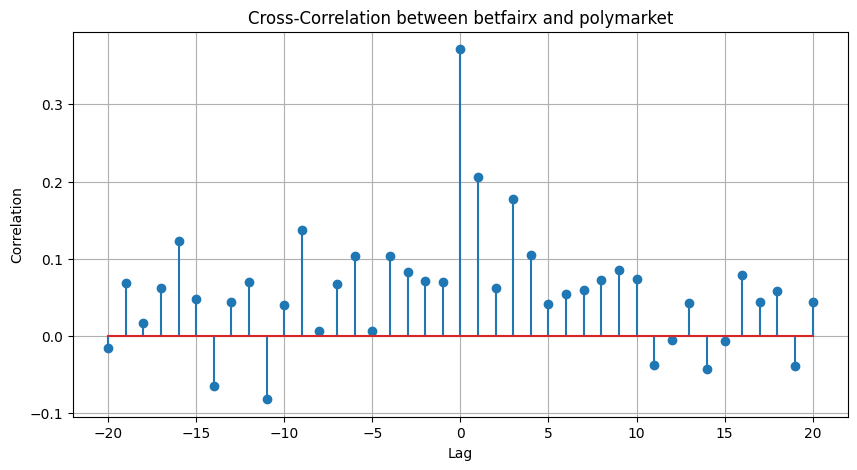

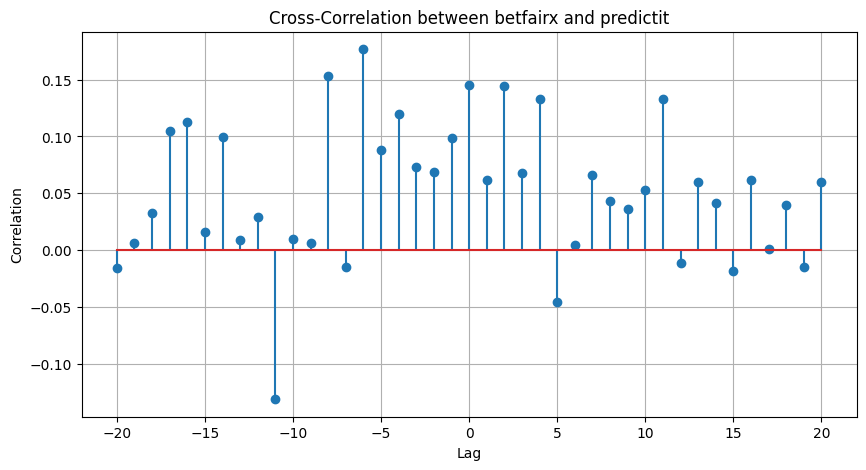

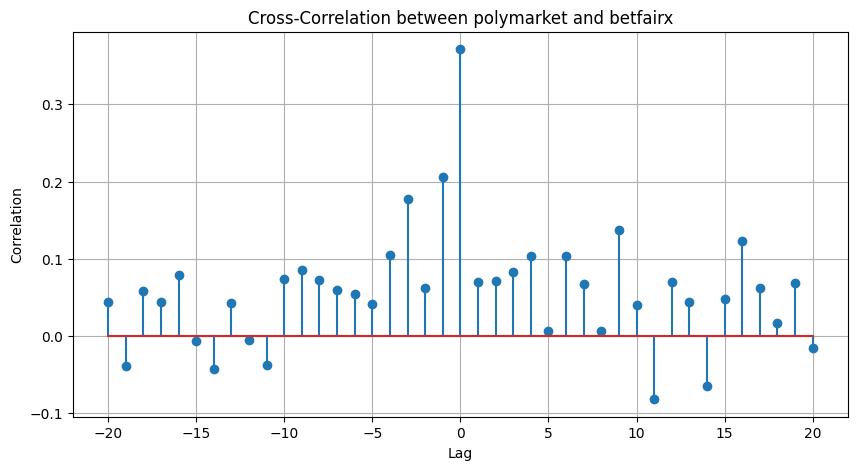

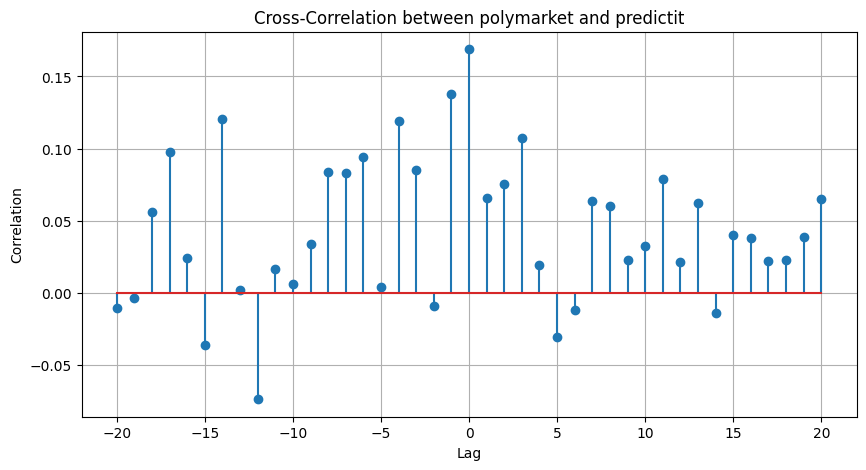

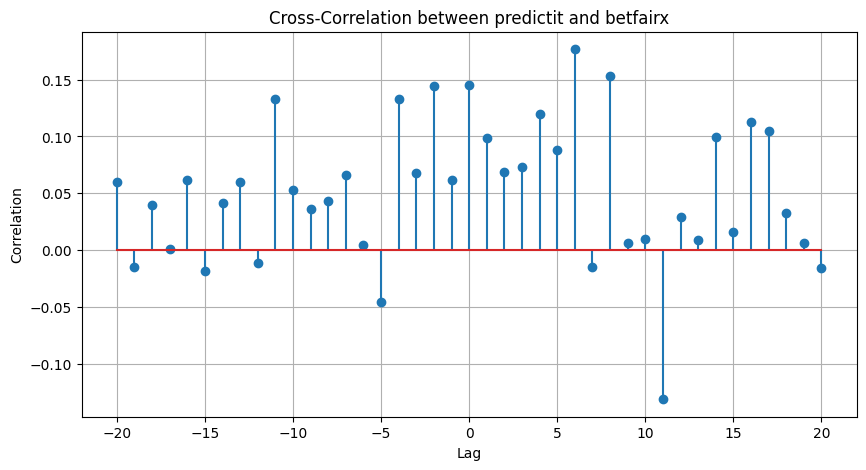

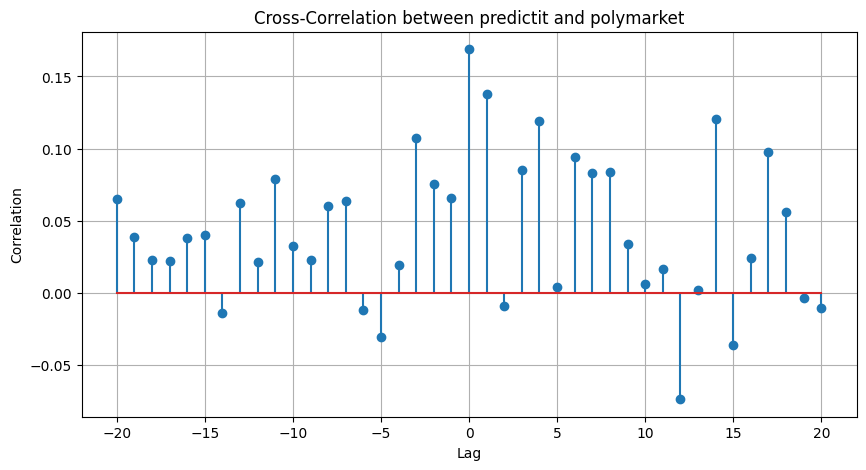

In [121]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming your DataFrame is named pivoted_market_data

# Select only the relevant columns
selected_columns = ['betfairx', 'polymarket', 'predictit']
selected_data = pivoted_market_data[selected_columns]

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    return {'Test Statistic': result[0], 'p-value': result[1], 'Stationary': result[1] < 0.05}

# Test stationarity for each selected column
stationarity_results = {col: check_stationarity(selected_data[col]) for col in selected_columns}
print("Stationarity Results:")
print(stationarity_results)

# If series is non-stationary, compute differences
selected_data_diff = selected_data.copy()
for col in selected_columns:
    selected_data_diff[col] = selected_data[col].diff()

# Drop NA values resulting from differencing
selected_data_diff.dropna(inplace=True)

# Function to compute cross-correlation
def compute_cross_correlation(series1, series2, max_lags):
    lags = np.arange(-max_lags, max_lags + 1)
    cross_corr = [series1.corr(series2.shift(lag)) for lag in lags]
    return lags, cross_corr

# Plot cross-correlation for the selected columns
max_lags = 20  # Define the maximum lag to check
for col1 in selected_columns:
    for col2 in selected_columns:
        if col1 != col2:
            lags, cross_corr = compute_cross_correlation(selected_data_diff[col1], selected_data_diff[col2], max_lags)
            plt.figure(figsize=(10, 5))
            plt.stem(lags, cross_corr)
            plt.title(f'Cross-Correlation between {col1} and {col2}')
            plt.xlabel('Lag')
            plt.ylabel('Correlation')
            plt.grid()
            plt.show()

In [122]:
correlation_matrix = selected_data_diff.corr()
print(correlation_matrix)

source      betfairx  polymarket  predictit
source                                     
betfairx    1.000000    0.371363   0.145145
polymarket  0.371363    1.000000   0.168924
predictit   0.145145    0.168924   1.000000


In [95]:
from statsmodels.tsa.stattools import grangercausalitytests

# Create a DataFrame with both time series
granger_data = pd.concat([ts_a, ts_b], axis=1)
granger_data.columns = [source_a, source_b]

# Drop missing values
granger_data.dropna(inplace=True)

In [96]:
maxlag = 10  # Test up to 10 lags

# Test if source_a Granger-causes source_b
print(f"Testing if {source_a} Granger-causes {source_b}:")
grangercausalitytests(granger_data[[source_b, source_a]], maxlag=maxlag, verbose=True)

# Test if source_b Granger-causes source_a
print(f"\nTesting if {source_b} Granger-causes {source_a}:")
grangercausalitytests(granger_data[[source_a, source_b]], maxlag=maxlag, verbose=True)

Testing if predictit Granger-causes polymarket:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.0321 , p=0.0000  , df_denom=1348, df_num=1
ssr based chi2 test:   chi2=25.0878 , p=0.0000  , df=1
likelihood ratio test: chi2=24.8577 , p=0.0000  , df=1
parameter F test:         F=25.0321 , p=0.0000  , df_denom=1348, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.3653 , p=0.0000  , df_denom=1345, df_num=2
ssr based chi2 test:   chi2=26.8300 , p=0.0000  , df=2
likelihood ratio test: chi2=26.5669 , p=0.0000  , df=2
parameter F test:         F=13.3653 , p=0.0000  , df_denom=1345, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.4397 , p=0.0000  , df_denom=1342, df_num=3
ssr based chi2 test:   chi2=31.4824 , p=0.0000  , df=3
likelihood ratio test: chi2=31.1207 , p=0.0000  , df=3
parameter F test:         F=10.4397 , p=0.0000  , df_denom=1342, df_num=3

Granger Causality
number of lags (no ze

/opt/homebrew/Caskroom/miniconda/base/envs/bfair/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/bfair/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (18.95119678574128, 1.4423801709972e-05, 1348.0, 1),
   'ssr_chi2test': (18.993373039715483, 1.3117324026957977e-05, 1),
   'lrtest': (18.861099775178445, 1.4059060832721654e-05, 1),
   'params_ftest': (18.951196785742574, 1.4423801709963211e-05, 1348.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (21.56205359538535, 6.06326818477321e-10, 1345.0, 2),
   'ssr_chi2test': (43.2844198569074, 3.989400629656743e-10, 2),
   'lrtest': (42.605000238807406, 5.603272547494633e-10, 2),
   'params_ftest': (21.562053595372415, 6.063268184849379e-10, 1345.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (14.381936174502757, 3.16932415488662e-09, 1342.0, 3),
   'ssr_chi2test': (43.3708611760154, 2.0528838493896123e-09, 3),
   'lrtest': (42.688258449705245, 2.8661229611224162e-09, 3),
   'params_ftest': (14.381936174498078, 3.1693241549078785e-09, 1342.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.

In [97]:
max_lag = 10  # Maximum lag to test
lagged_correlations = []

for lag in range(-max_lag, max_lag + 1):
    if lag < 0:
        shifted_ts_a = ts_a.shift(-lag)
        shifted_ts_b = ts_b
    else:
        shifted_ts_a = ts_a
        shifted_ts_b = ts_b.shift(lag)
    
    # Compute correlation
    corr = shifted_ts_a.corr(shifted_ts_b)
    lagged_correlations.append({'lag': lag, 'correlation': corr})

# Create DataFrame
lagged_corr_df = pd.DataFrame(lagged_correlations)

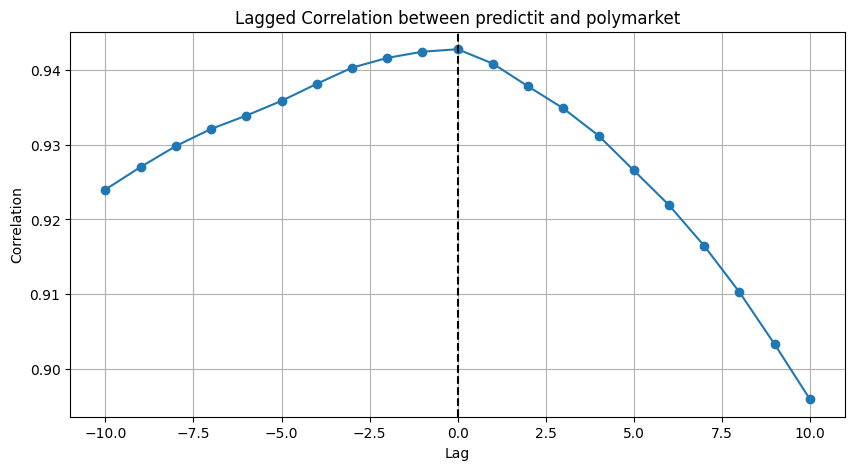

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(lagged_corr_df['lag'], lagged_corr_df['correlation'], marker='o')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title(f'Lagged Correlation between {source_a} and {source_b}')
plt.axvline(x=0, color='k', linestyle='--')
plt.grid(True)
plt.show()

In [116]:
ts_a.head(n=10)
#ts_b.head(n=10)

2023-01-01 00:05:00     6.274121
2023-01-01 00:06:00     7.224209
2023-01-01 00:07:00     7.072852
2023-01-01 00:08:00     6.969633
2023-01-01 00:09:00     7.380232
2023-01-01 00:10:00     7.524275
2023-01-01 00:11:00     8.978549
2023-01-01 00:12:00     9.739587
2023-01-01 00:13:00     9.861262
2023-01-01 00:14:00    10.305125
Freq: min, dtype: float64

#### Plots

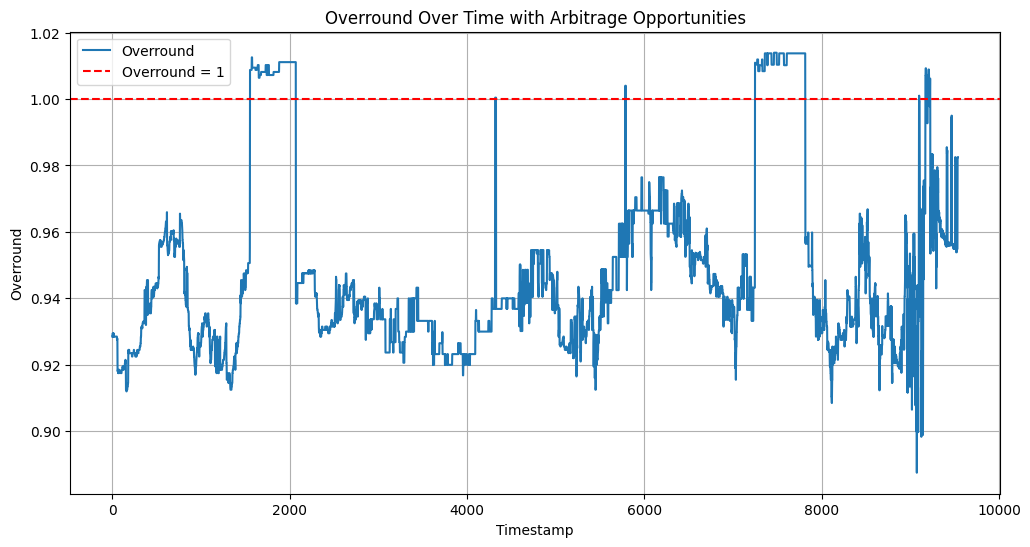

In [56]:
import matplotlib.dates as mdates

# Plot overround over time
plt.figure(figsize=(12, 6))
plt.plot(best_odds_pivot.index, best_odds_pivot['overround'], label='Overround')


plt.axhline(y=1, color='r', linestyle='--', label='Overround = 1')
plt.title('Overround Over Time with Arbitrage Opportunities')
plt.xlabel('Timestamp')
plt.ylabel('Overround')
plt.legend()
plt.grid(True)
plt.show()

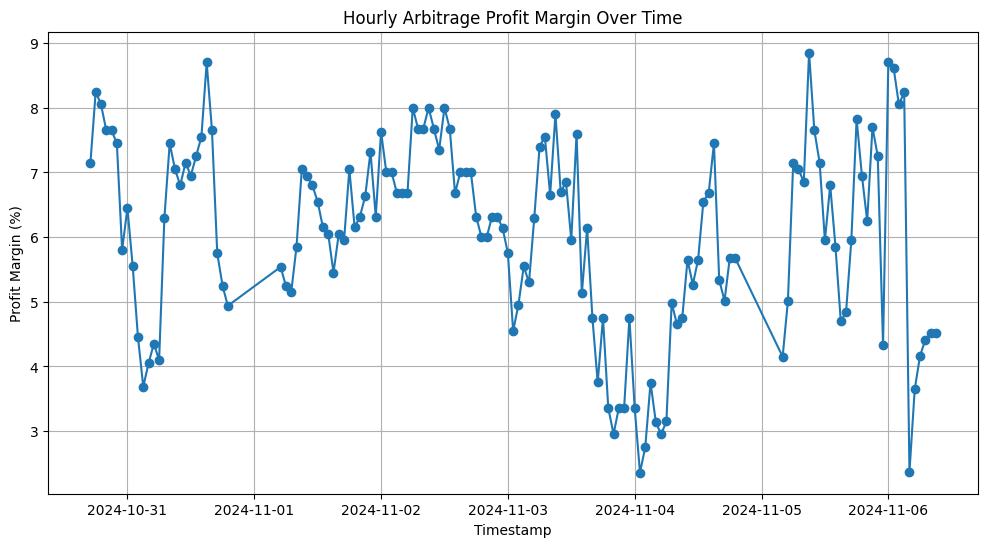

In [76]:
# Plot profit margin over time
plt.figure(figsize=(12, 6))
plt.plot(arbitrage_opportunities['timestamp'], arbitrage_opportunities['profit_margin'], marker='o')
plt.title('Hourly Arbitrage Profit Margin Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Profit Margin (%)')
plt.grid(True)
plt.show()